In [31]:
import xarray as xr
from minisom import MiniSom
import pandas as pd


In [8]:
ds = xr.open_dataset('zg_day_reanalysis_era5_r1i1p1-050000Pa_19800101-19801231.nc',decode_times = True)

ds = ds.sortby(ds.lon)

da = ds['zg']

y = da['lat']
x = da['lon']

In [12]:
import numpy as np
from minisom import MiniSom

# Extract Zg data for all time steps
zg_data = da.values  # Assuming this results in a numpy array

# Reshape data to (days, lat, lon) - MiniSom requires 3D input
days, lat, lon = zg_data.shape
zg_data_3d = zg_data.reshape(days, lat * lon)

# Define SOM parameters
som_shape = (8,5)  # Grid shape for SOM
input_len = lat * lon  # Input dimensionality

# Initialize the SOM
som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=0.3, learning_rate=0.5)

# Train the SOM
som.random_weights_init(zg_data_3d)
som.train_random(zg_data_3d, 1000)  # Adjust the number of epochs as needed

# Obtain the SOM node grid
node_grid = np.zeros(som_shape)
for i in range(days):
    winner = som.winner(zg_data_3d[i])
    node_grid[winner] += 1

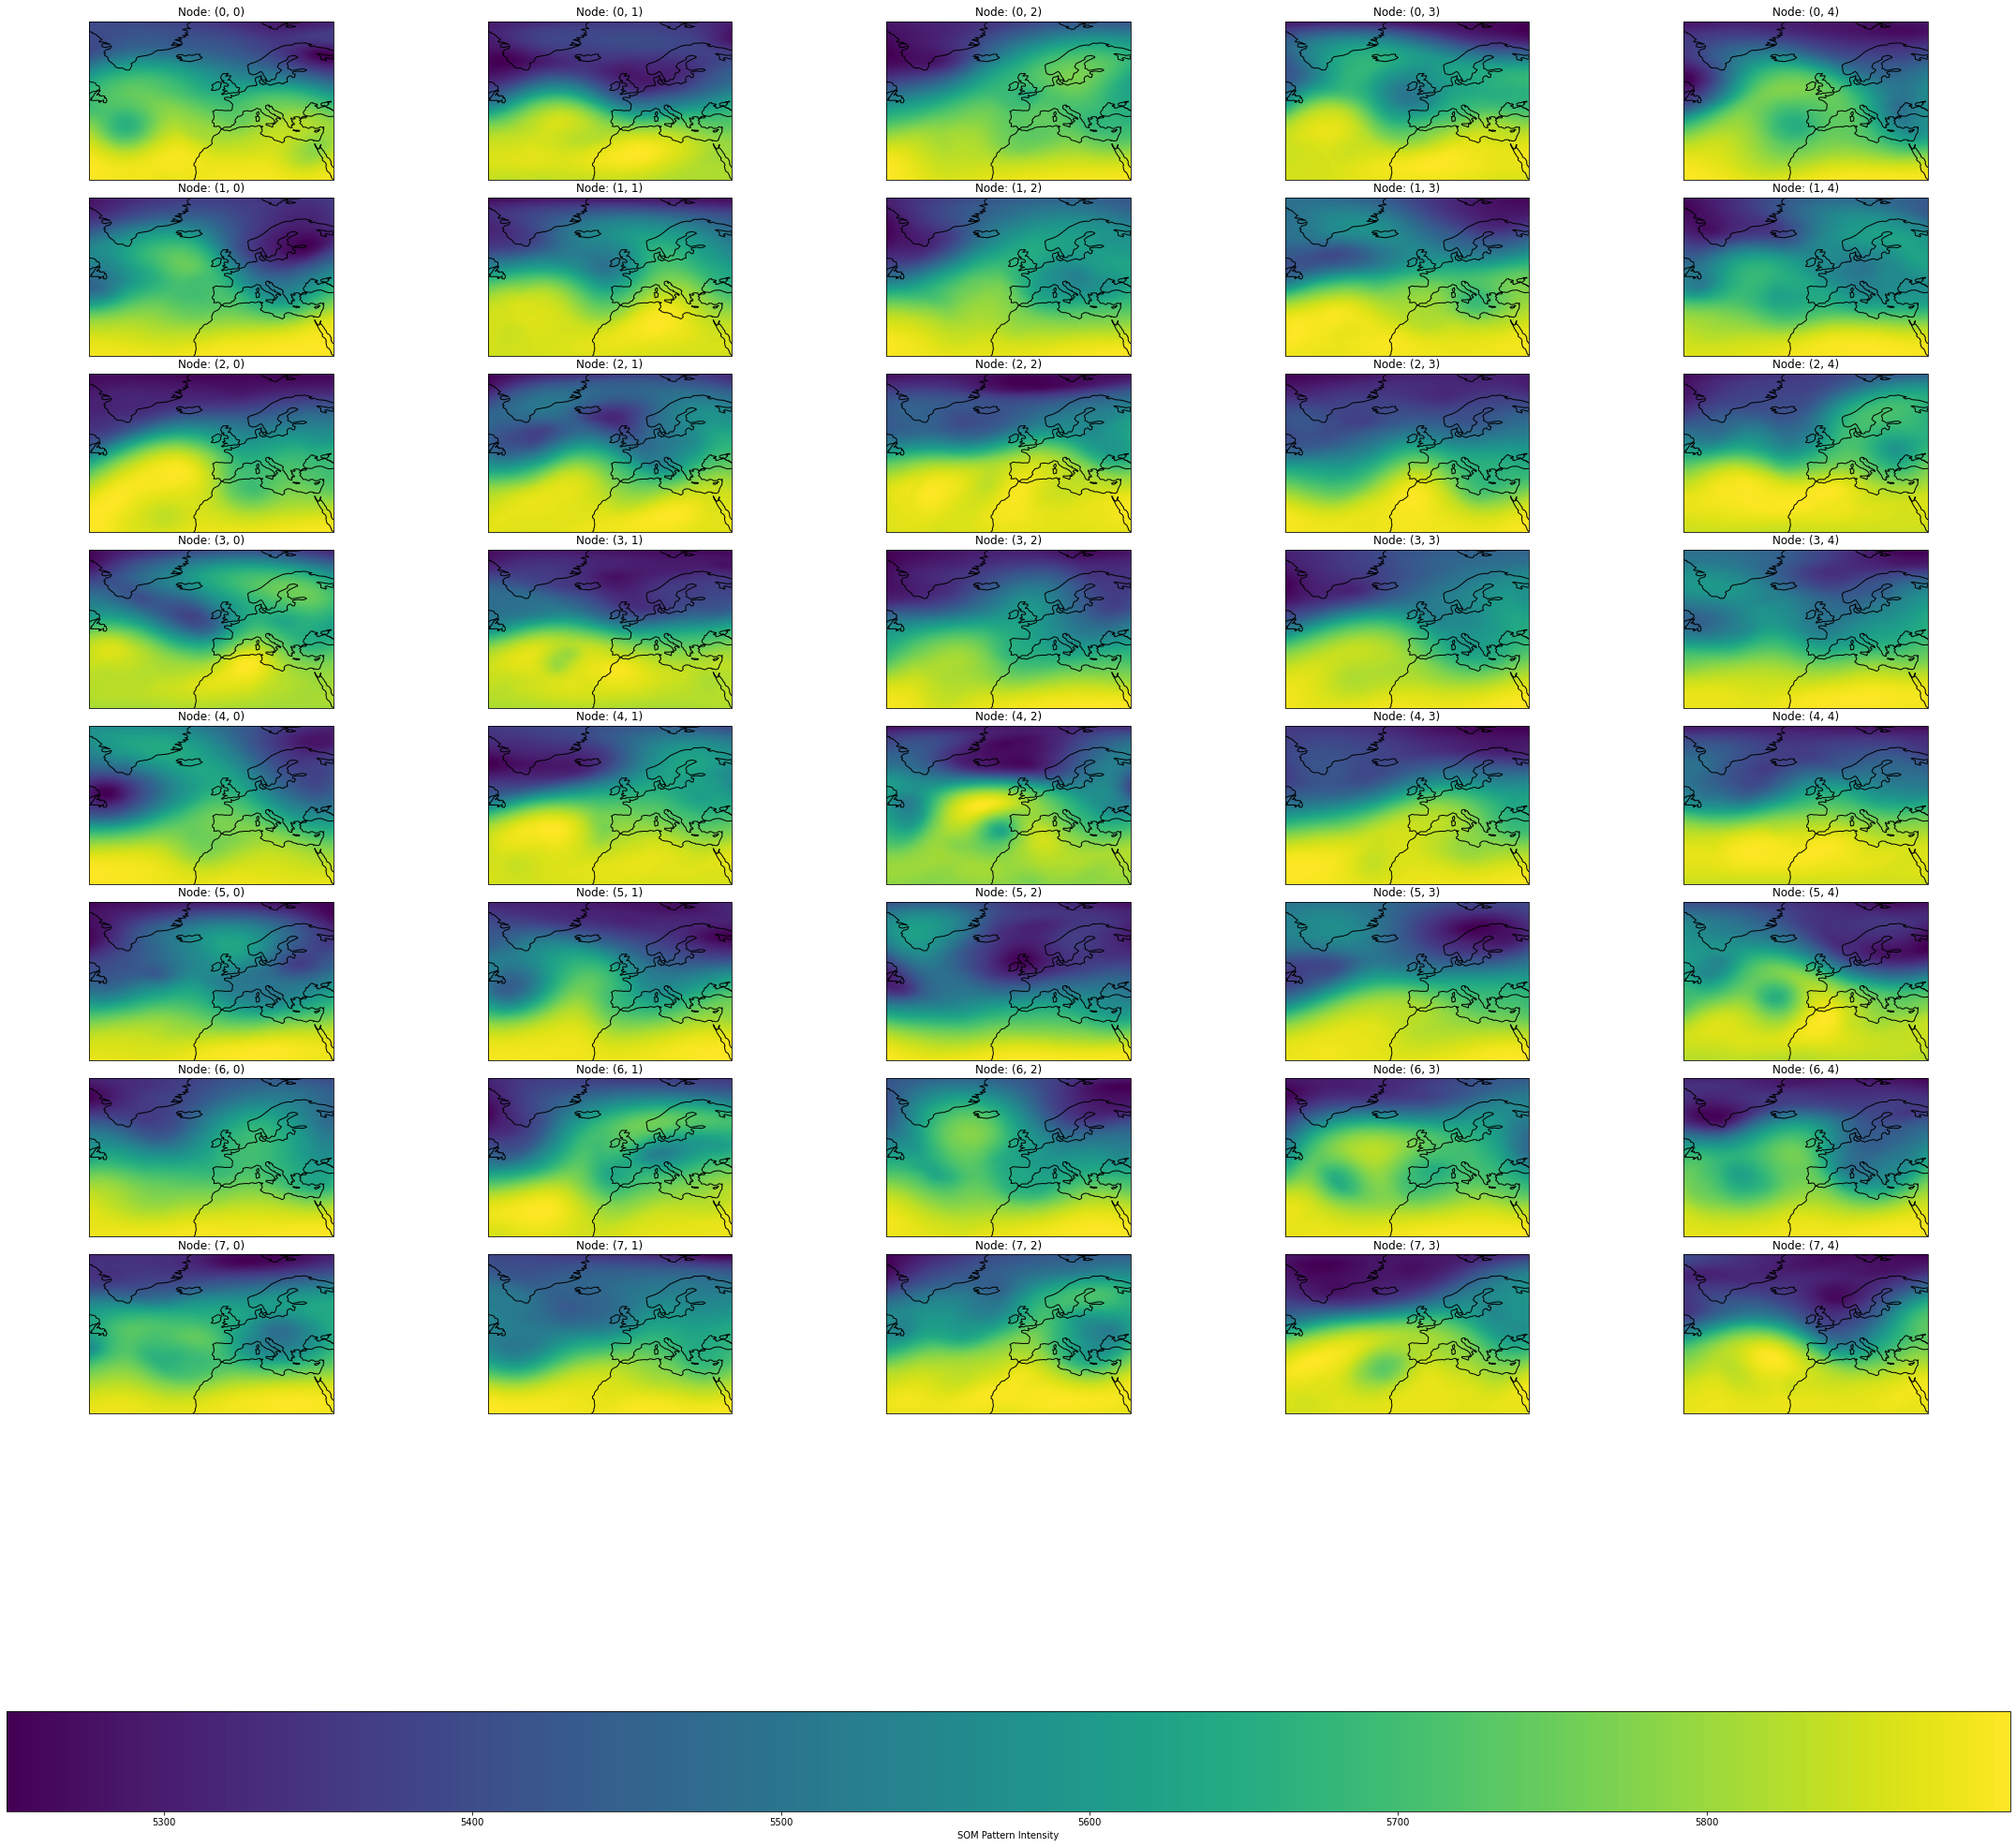

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_som_on_map_grid(som, lat, lon):
    som_shape = som.get_weights().shape[:2]
    fig, axs = plt.subplots(som_shape[0], som_shape[1], figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
    
    for i in range(som_shape[0]):
        for j in range(som_shape[1]):
            ax = axs[i, j]
            ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
            
            node_pattern = som.get_weights()[i, j].reshape(lat.shape[0], lon.shape[0])  # Reshape SOM node pattern
            im = ax.imshow(node_pattern, origin='lower', extent=(lon.min(), lon.max(), lat.min(), lat.max()),
                           transform=ccrs.PlateCarree(), cmap='viridis')  # Display pattern on map
            ax.set_title(f'Node: ({i}, {j})')
            ax.coastlines()

    plt.tight_layout()
    plt.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', label='SOM Pattern Intensity')
    plt.show()

# Assuming latitudes and longitudes are available in the variables 'y' and 'x' respectively
plot_som_on_map_grid(som, y, x)


In [29]:
# Calculate centroids and associate with time
centroids = []
times = []

for node, data_indices in mapping.items():
    # Convert data_indices to integer type
    data_indices = np.array(data_indices).astype(int)
    
    # Print data indices for debugging
    print("Data indices:", data_indices)
    
    # Filter out-of-bounds indices
    valid_indices = data_indices[(data_indices >= 0) & (data_indices < days)]
    
    # Print valid indices for debugging
    print("Valid indices:", valid_indices)
    
    if len(valid_indices) == 0:
        # If no valid indices remain, skip this node
        continue
    
    # Calculate centroid
    centroid = np.mean(zg_data_3d[valid_indices], axis=0)
    centroids.append(centroid)
    
    # Associate centroid with time (assuming time index is same as node index)
    times.append(node)

# Convert times to dates
time_dates = da.time[times]

# Now, 'centroids' contains the centroid values for each cluster,
# and 'time_dates' contains the corresponding time indices as dates.


Data indices: [[5859 5859 5859 ... 4922 4925 4927]
 [5865 5865 5866 ... 5122 5123 5125]
 [5885 5885 5885 ... 5182 5183 5184]
 ...
 [5863 5863 5863 ... 5178 5179 5180]
 [5850 5850 5850 ... 5099 5099 5099]
 [5846 5847 5847 ... 5084 5084 5085]]
Valid indices: []
Data indices: [[5860 5860 5860 ... 4886 4888 4890]
 [5864 5865 5865 ... 4894 4895 4895]
 [5838 5839 5838 ... 5084 5084 5084]
 ...
 [5858 5858 5858 ... 5088 5089 5090]
 [5862 5862 5861 ... 5150 5151 5151]
 [5860 5860 5859 ... 5201 5202 5202]]
Valid indices: []
Data indices: [[5873 5873 5873 ... 5053 5053 5053]
 [5879 5879 5879 ... 5036 5036 5036]
 [5849 5849 5848 ... 5144 5143 5142]
 ...
 [5879 5878 5878 ... 4965 4967 4970]
 [5875 5874 5874 ... 4973 4974 4976]
 [5884 5884 5883 ... 5008 5007 5007]]
Valid indices: []
Data indices: [[5877 5877 5877 ... 4977 4976 4976]
 [5882 5882 5882 ... 5001 4999 4997]
 [5885 5885 5884 ... 5020 5018 5015]
 ...
 [5880 5880 5880 ... 5211 5211 5212]
 [5870 5871 5871 ... 5188 5189 5190]
 [5861 5861 5861

In [32]:
spree_data = pd.read_csv('Spree_droughts.csv')


### Spree data (period of at least 14 days (or more) with daily precipitation values < 1 mm/day)
### The mean value of all gridcells was calculated, resulting in one average precipitation value per day for the whole region.¶

In [35]:
spree_data

,Unnamed: 0,time,pr
0,7,1980-01-08,0.170490
1,8,1980-01-09,0.329401
2,9,1980-01-10,0.335126
3,10,1980-01-11,0.172844
4,11,1980-01-12,0.115111
...,...,...,...
1351,14948,2020-12-04,0.008057
1352,14949,2020-12-05,0.404438
1353,14950,2020-12-06,0.715474
1354,14951,2020-12-07,0.408073


In [36]:
# Step 1: Create a new column to indicate drought status
spree_data['drought'] = 0  # Initialize with non-drought values (0 means no drought)

# Step 2: Mark rows corresponding to drought days
spree_data.loc[:, 'drought'] = 1  # Mark all existing rows as drought days

# Step 3: Fill in missing dates with non-drought values
# Assuming the 'time' column is datetime type, if not, convert it first
spree_data['time'] = pd.to_datetime(spree_data['time'])

In [38]:
# Generate a range of dates from 1980-01-01 to 2020-12-31
date_range = pd.date_range(start='1980-01-01', end='2020-12-31')

# Fill in missing dates with non-drought values
missing_dates = date_range[~date_range.isin(spree_data['time'])]
missing_data = pd.DataFrame({'time': missing_dates, 'pr': 0, 'drought': 0})
spree_data = pd.concat([spree_data, missing_data]).sort_values('time').reset_index(drop=True)


In [39]:
# Optionally, sort the DataFrame by date
spree_data = spree_data.sort_values('time').reset_index(drop=True)

In [42]:
#dropping unnamed column
spree_data.drop(columns=['Unnamed: 0'], inplace=True)


In [44]:
spree_data.head(10)

,time,pr,drought
0,1980-01-01,0.000000,0
1,1980-01-02,0.000000,0
2,1980-01-03,0.000000,0
3,1980-01-04,0.000000,0
4,1980-01-05,0.000000,0
5,1980-01-06,0.000000,0
6,1980-01-07,0.000000,0
7,1980-01-08,0.170490,1
8,1980-01-09,0.329401,1
9,1980-01-10,0.335126,1


In [53]:
# Assuming spree_data['time'] is already in datetime format
start_date = '1980-01-01'
end_date = '1980-12-31'

# Filter the DataFrame to include only the rows within the specified date range
filtered_spree_data = spree_data[(spree_data['time'] >= start_date) & (spree_data['time'] <= end_date)]

In [54]:
filtered_spree_data

,time,pr,drought,cluster_number
0,1980-01-01,0.0,0,27.0
1,1980-01-02,0.0,0,18.0
2,1980-01-03,0.0,0,18.0
3,1980-01-04,0.0,0,37.0
4,1980-01-05,0.0,0,37.0
...,...,...,...,...
361,1980-12-27,0.0,0,11.0
362,1980-12-28,0.0,0,11.0
363,1980-12-29,0.0,0,11.0
364,1980-12-30,0.0,0,11.0


In [55]:
# Assuming 'node_grid' contains the array containing cluster information
# For each time step, find the corresponding cluster using the time dimension
for i in range(days):
    # Find the winning cluster for the current time step
    winner = som.winner(zg_data_3d[i])
    filtered_spree_data.at[i, 'cluster_number'] = np.ravel_multi_index(winner, som_shape) + 1  # Adding 1 to index to get cluster number from 1 to 40


In [56]:
  filtered_spree_data

,time,pr,drought,cluster_number
0,1980-01-01,0.0,0,27.0
1,1980-01-02,0.0,0,18.0
2,1980-01-03,0.0,0,18.0
3,1980-01-04,0.0,0,37.0
4,1980-01-05,0.0,0,37.0
...,...,...,...,...
361,1980-12-27,0.0,0,11.0
362,1980-12-28,0.0,0,11.0
363,1980-12-29,0.0,0,11.0
364,1980-12-30,0.0,0,11.0


In [57]:
# Define a mapping dictionary
drought_mapping = {0: 'Non-Drought', 1: 'Drought'}

# Use the map function to create a new column based on the mapping
filtered_spree_data['drought_status'] = filtered_spree_data['drought'].map(drought_mapping)


<ipython-input-57-8ce70b7ce5fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_spree_data['drought_status'] = filtered_spree_data['drought'].map(drought_mapping)


In [58]:
filtered_spree_data


,time,pr,drought,cluster_number,drought_status
0,1980-01-01,0.0,0,27.0,Non-Drought
1,1980-01-02,0.0,0,18.0,Non-Drought
2,1980-01-03,0.0,0,18.0,Non-Drought
3,1980-01-04,0.0,0,37.0,Non-Drought
4,1980-01-05,0.0,0,37.0,Non-Drought
...,...,...,...,...,...
361,1980-12-27,0.0,0,11.0,Non-Drought
362,1980-12-28,0.0,0,11.0,Non-Drought
363,1980-12-29,0.0,0,11.0,Non-Drought
364,1980-12-30,0.0,0,11.0,Non-Drought


In [62]:
# Count the occurrences of each unique value in the 'drought_status' column
drought_status_counts = filtered_spree_data['drought_status'].value_counts()

# Display the counts
drought_status_counts


Non-Drought    334
Drought         32
Name: drought_status, dtype: int64

In [61]:
# Filter the DataFrame to include only drought days
drought_days = filtered_spree_data[filtered_spree_data['drought_status'] == 'Drought']

drought_days


,time,pr,drought,cluster_number,drought_status
7,1980-01-08,0.170490,1,8.0,Drought
8,1980-01-09,0.329401,1,8.0,Drought
9,1980-01-10,0.335126,1,8.0,Drought
10,1980-01-11,0.172844,1,8.0,Drought
11,1980-01-12,0.115111,1,34.0,Drought
12,1980-01-13,0.018120,1,34.0,Drought
13,1980-01-14,0.000320,1,33.0,Drought
14,1980-01-15,0.028527,1,33.0,Drought
15,1980-01-16,0.180990,1,18.0,Drought
16,1980-01-17,0.071522,1,18.0,Drought
